In [5]:
from pylab import *
from __future__ import division
import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA
import time

%matplotlib inline

In [460]:
def norm_range(v):
    return (v-v.min())/(v.max()-v.min())

# Storing image sequence in the hypervector

A further generalization of the capacity analysis is to consider storing images in a hypervector. To store images, we utilize a clean-up memory, which is a set of basis vectors that serve to represent the image. This is the same as the alphabet, and we will have $D$ tokens to serve to represent the images.

First, I will load a ton of random image patches from an ImageNet database and create the basis vectors. I am going to use both pca (which will give me a "dense" representation of the image), and then I am going to perform ICA on the pca-reduced data, and get another set of basis vectors (these are a "sparse" representation of the image).


In [ ]:
reload(imut)
patch_size=(40,40)
tsart = time.time()
impatches = imut.load_random_imnet_patches(10000, patch_size=patch_size)
print "Duration: ", time.time() - tstart


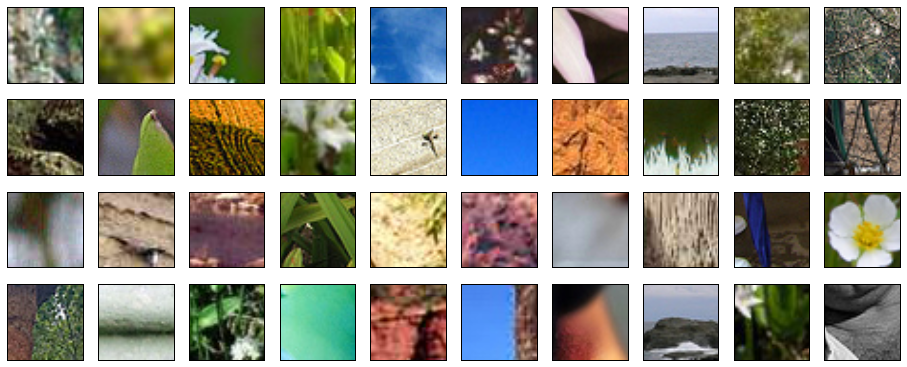

In [523]:

figure(figsize=(16,8))
nshow = 40
maxrow=10
for i in range(nshow):
    ax=subplot(nshow//maxrow + 1, maxrow,i+1)
    imshow(norm_range(impatches[:,:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])

** Figure 1: Sample image patches from the database. **

So, we are first going to turn all of our images into a matrix, just a sanity check to make shure the reshaping is done correctly.

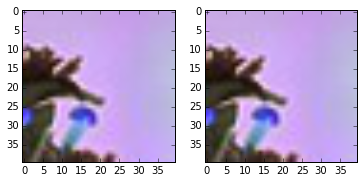

In [510]:
impatchr = impatches.reshape((-1, impatches.shape[3]))

irec = impatchr[:, 2].reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2]))

subplot(121)
imshow(impatches[:,:,:,2])
subplot(122)
imshow(irec)

In [511]:
impatchr.shape

(4800, 10000)

Next, we do PCA-ICA anlaysis (this is actually the same as what I do with calcium imaging and vsd imaging) to get the basis vectors. We will use a set of `ncomponents=400` basis vectors. 

In [498]:

ncomponents = 400

pca_encoder = PCA(ncomponents)
fica_encoder = FastICA(ncomponents)



In [ ]:
tstart = time.time()
pca_encoder.fit(impatchr.T)
print 'Duration: ', time.time() - tstart


In [512]:
scores = pca_encoder.transform(impatchr.T)

In [513]:
scores.shape

(10000, 400)

scores is the image data in the pca basis space -- i.e. there are 10,000 images and 400 pc basis vectors. Lets look at the basis vectors.

In [514]:
pc_comp = pca_encoder.components_

print pc_comp.shape

pc_comp_ims = pc_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))

(400, 4800)


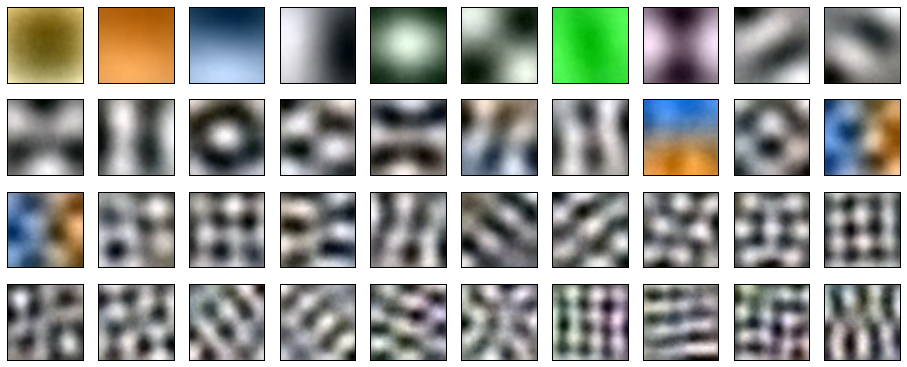

In [524]:
figure(figsize=(16,8))
nshow = 40
maxrow=10
for i in range(nshow):
    ax=subplot(nshow//maxrow+1,maxrow,i+1)
    imshow(norm_range(pc_comp_ims[:,:,:,i]))
    ax.set_xticks([])
    ax.set_yticks([])


** Figure 2: Basis images of top PCA components**

So, to get a sparse basis, we perform ICA on the image data (we used the dimensionality-reduced image data). This will actually give us just a linear projection of the same set of basis vectors that the PCA analysis provides. This means that the reconstruction of the image from either the PCA or ICA basis vectors should be exactly the same. 

In [520]:
tstart = time.time()
fica_encoder.fit(scores)
print 'Duration: ', time.time() - tstart


Duration:  76.4628169537


In [521]:
ic_comp = fica_encoder.components_
ic_comp /= ic_comp.std(axis=0)
ic_comp = np.dot(ic_comp, pc_comp)
print ic_comp.shape

(400, 4800)


Here is what some of the ICA basis vectors look like. We get a bunch of cool Gabor filters and color opponency edges.

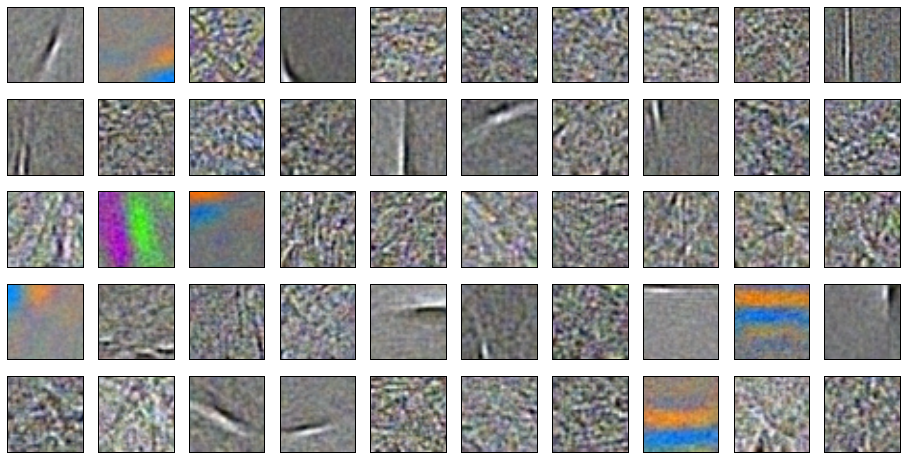

In [530]:
ic_comp_ims = ic_comp.T.reshape((impatches.shape[0], impatches.shape[1], impatches.shape[2], -1))
figure(figsize=(16,8))
nshow = 50
maxrow=10
for i in range(nshow):
    ax=subplot(nshow//maxrow,maxrow,i+1)
    imshow(norm_range(ic_comp_ims[:,:,:,i+100]))
    ax.set_xticks([])
    ax.set_yticks([])

** Figure 3: Sample of ICA basis vectors **

We can use these basis vectors to then represent an image. We just get a new random patch from the data base and use a linear regression (there are probably slightly better things than this, but not the point) of the image with the basis vectors to get a histogram of coefficients for each vector and that is the `pc_code` or `ic_code` that represents the image. Here is an image encoded into the basis and reconstructed, as well as the histogram of the coefficients (note we take out the mean of the image, which occasionally makes things look different because of renormalization).

In [583]:
nrecon = 10
impatch = imut.load_random_imnet_patches(nrecon, patch_size)
#impatch = impatches[:,:,:,58]
impatchr = impatch.reshape((-1, nrecon))
ic_c = linalg.lstsq(ic_comp.T, impatchr - np.mean(impatchr))
pc_c = linalg.lstsq(pc_comp.T, impatchr - np.mean(impatchr))
ic_code = ic_c[0].T
pc_code = pc_c[0].T

0


In [586]:
ic_code.shape

(10, 400)

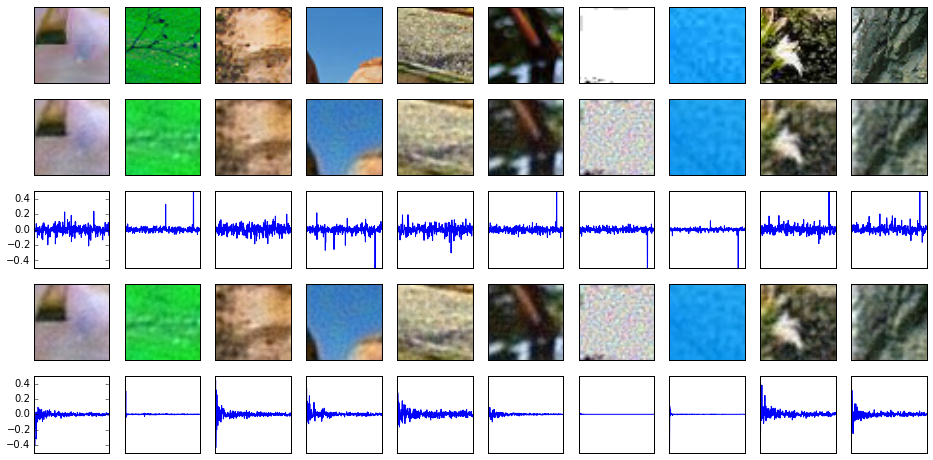

In [597]:


figure(figsize=(16, 8))

for imx in range(nrecon):
    
    ax = subplot(5, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(5, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

    ax = subplot(5, nrecon, imx + 1 + 3*nrecon)
    pc_recon = np.dot(pc_code[imx,:], pc_comp)
    pc_reconr = pc_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(pc_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(5, nrecon, imx + 1 + 4*nrecon)
    plot(pc_code[imx,:].T/norm(pc_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])


** Figure 4: PCA and ICA vector encoding of new image patches. ** Top row: original image. Second row: ICA basis reconstruction of the image. Third row: histogram of ICA basis coefficients. Fourth row: PCA basis reconstruction of image. Bottom row: histogram of PCA basis coefficients.



In [591]:
np.allclose(ic_recon, pc_recon)

True

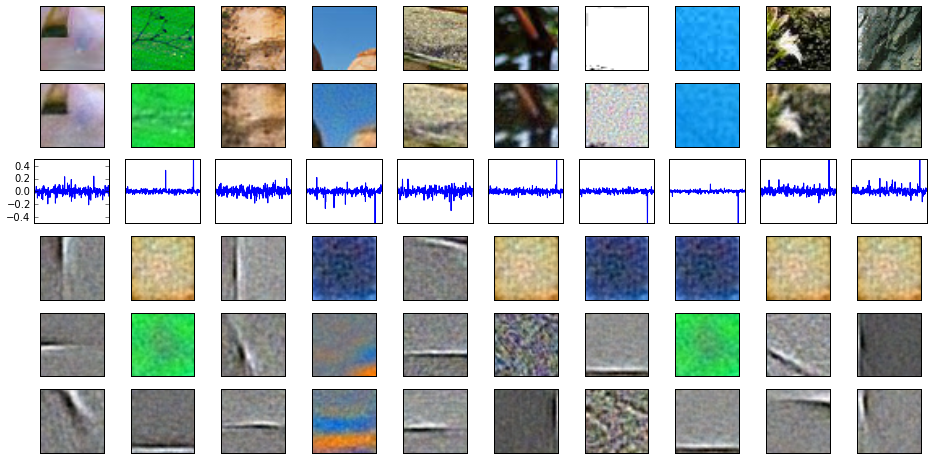

In [604]:
figure(figsize=(16, 8))

for imx in range(nrecon):
    
    ax = subplot(6, nrecon, imx + 1)
    imp = impatchr[:,imx].reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(imp))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(6, nrecon, imx + 1 + nrecon)
    ic_recon = np.dot(ic_code[imx,:], ic_comp)
    ic_reconr = ic_recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(ic_reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax = subplot(6, nrecon, imx + 1 + 2*nrecon)
    plot(ic_code[imx,:].T/norm(ic_code[imx, :]))
    ax.set_xticks([])
    ax.set_ylim([-0.5, 0.5])
    if imx > 0:
        ax.set_yticks([])

        
    ax = subplot(6, nrecon, imx + 1 + 3*nrecon)
    idx_max = np.argsort(abs(ic_code[imx,:]))
    
    ic_compr = ic_comp[idx_max[-1],:].reshape(patch_size[0], patch_size[1], 3) 
    ic_compr = ic_compr * ic_code[imx, idx_max[-1]] # this just flips it if its negative
    imshow(norm_range(ic_compr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(6, nrecon, imx + 1 + 4*nrecon)
    
    ic_compr = ic_comp[idx_max[-2],:].reshape(patch_size[0], patch_size[1], 3) 
    ic_compr = ic_compr * ic_code[imx, idx_max[-2]] # this just flips it if its negative
    imshow(norm_range(ic_compr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(6, nrecon, imx + 1 + 5*nrecon)
    
    ic_compr = ic_comp[idx_max[-3],:].reshape(patch_size[0], patch_size[1], 3) 
    ic_compr = ic_compr * ic_code[imx, idx_max[-3]] # this just flips it if its negative
    imshow(norm_range(ic_compr))
    ax.set_xticks([])
    ax.set_yticks([])

** Figure 5: Maximum ICA component visualization. ** Top three rows: same as Figure 4. Bottom rows: The component with the top coefficients that encodes the image and is displayed.

Pretty surprisingly, 7/10 of the images have the same largest ICA component (some are dark blueish some bright yellowish, because of negative sign). This seems to be one of the primary color/light-dark opponenecy components. 

Next, we encode the basis histograms into the hypervector, and we will encode a sequence of images using trajectory-association. 

In [607]:
N = 1e5
ic_hyperpatch = 2*(np.random.randn(ncomponents, int(N)) < 0) - 1
pc_hyperpatch = 2*(np.random.randn(ncomponents, int(N)) < 0) - 1

Mmax = 500
test_ims = imut.load_random_imnet_patches(Mmax, patch_size)

test_imr = test_ims.reshape((-1, Mmax))
test_imr = test_imr - test_imr.mean(axis=1)[:, np.newaxis]

ic_c = linalg.lstsq(ic_comp.T, test_imr)
pc_c = linalg.lstsq(pc_comp.T, test_imr)

ic_code = ic_c[0].T
pc_code = pc_c[0].T

print ic_code.shape

0 (500, 400)


In [608]:
K = 1

ic_hyperimage = np.zeros(N)
pc_hyperimage = np.zeros(N)

ic_decode = np.zeros_like(ic_code)
pc_decode = np.zeros_like(pc_code)

ic_decode1 = np.zeros_like(ic_code)
pc_decode1 = np.zeros_like(pc_code)

for imx in range(Mmax):
    ic_hypercode = np.dot(ic_code[imx, :] / norm(ic_code[imx,:]), ic_hyperpatch)
    pc_hypercode = np.dot(pc_code[imx, :] / norm(pc_code[imx,:]), pc_hyperpatch)
        
    ic_hyperimage = np.roll(ic_hyperimage, 1) + ic_hypercode
    pc_hyperimage = np.roll(pc_hyperimage, 1) + pc_hypercode
    
    ic_decode[imx, :] = np.dot(ic_hyperpatch, np.roll(ic_hyperimage, -K).T)
    pc_decode[imx, :] = np.dot(pc_hyperpatch, np.roll(pc_hyperimage, -K).T)

    ic_decode1[imx, :] = np.dot(ic_hyperpatch, np.roll(ic_hyperimage, -imx+K).T)
    pc_decode1[imx, :] = np.dot(pc_hyperpatch, np.roll(pc_hyperimage, -imx+K).T)
    

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


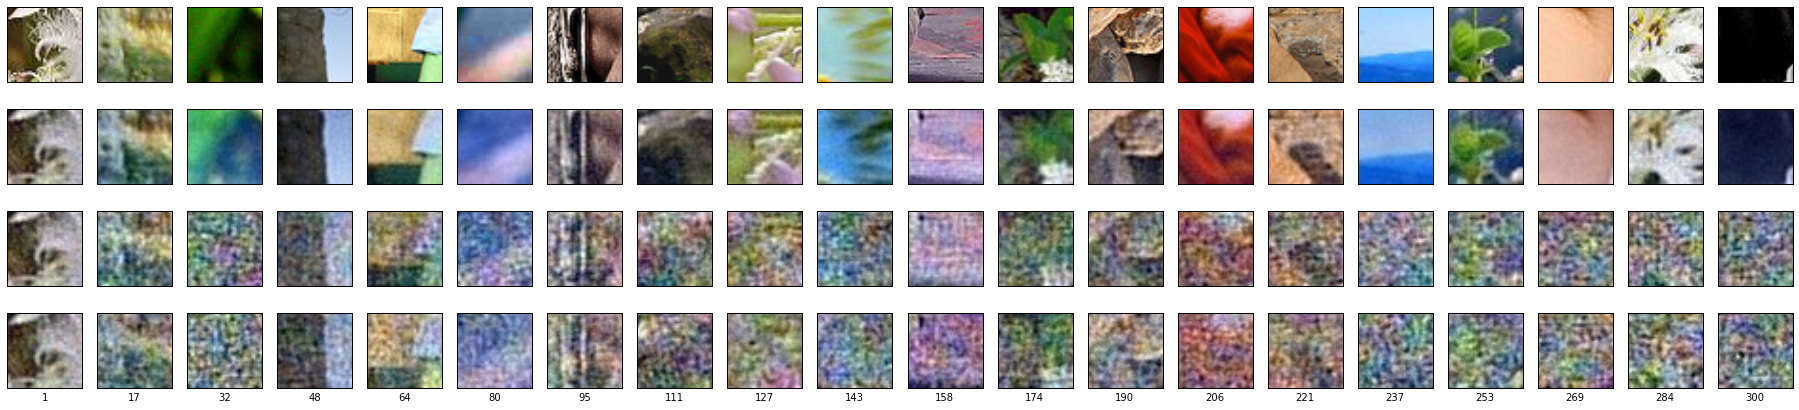

In [609]:

m_samp = np.round(linspace(1, 300, 20))

figure(figsize=(32,7))
for ix,imx in enumerate(m_samp):
    
    ax = subplot(4, len(m_samp), ix+1)
    imshow(norm_range(test_ims[:,:,:,imx]))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(4, len(m_samp), ix+1+len(m_samp))
    recon = np.dot(ic_code[imx,:], ic_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(4, len(m_samp), ix+1+2*len(m_samp))
    recon = np.dot(ic_decode[imx+K,:], ic_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(4, len(m_samp), ix+1+3*len(m_samp))
    recon = np.dot(pc_decode[imx+K,:], pc_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel(str(int(imx)))

** Figure 6: Recall of the K=1 most recently stored image. ** Top row: original image. Middle row: direct reconstruction of image from component basis. Third row: decoded reconstruction of the image from hypervector with ICA basis. Bottom row: decoded reconstruction of the image of image from hypervector with PCA basis. Numbers at bottom indicate total number of images stored in the hypervector (minus 1). 

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


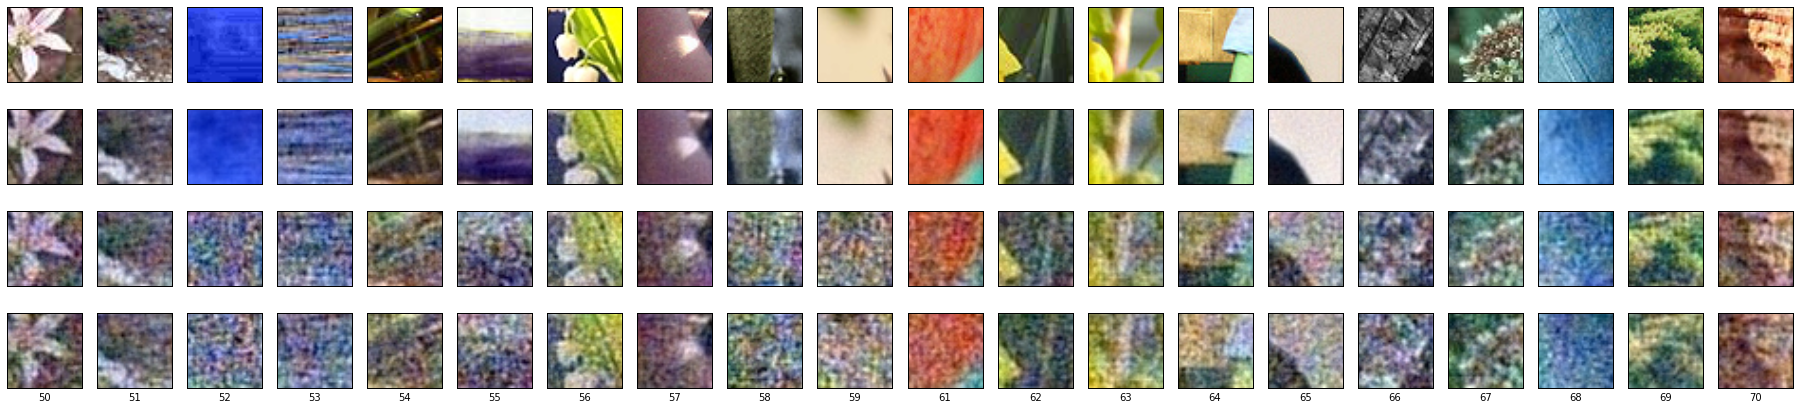

In [612]:

m_samp = np.round(linspace(50, 70, 20))

figure(figsize=(32,7))
for ix,imx in enumerate(m_samp):
    
    ax = subplot(4, len(m_samp), ix+1)
    imshow(norm_range(test_ims[:,:,:,imx]))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(4, len(m_samp), ix+1+len(m_samp))
    recon = np.dot(ic_code[imx,:], ic_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(4, len(m_samp), ix+1+2*len(m_samp))
    recon = np.dot(ic_decode[imx+K,:], ic_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(4, len(m_samp), ix+1+3*len(m_samp))
    recon = np.dot(pc_decode[imx+K,:], pc_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel(str(int(imx)))

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


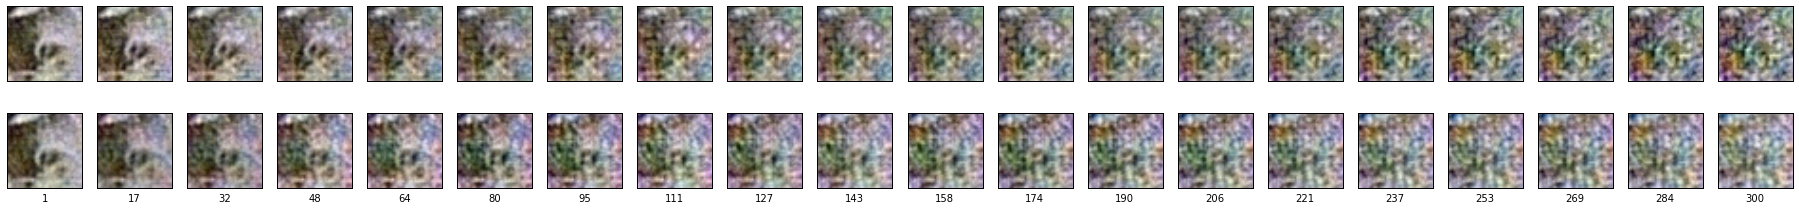

In [613]:

m_samp = np.round(linspace(1, 300, 20))

figure(figsize=(32,3.5))
for ix,imx in enumerate(m_samp):
    
    ax = subplot(2, len(m_samp), ix+1+0*len(m_samp))
    recon = np.dot(ic_decode1[imx+K,:], ic_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(2, len(m_samp), ix+1+1*len(m_samp))
    recon = np.dot(pc_decode1[imx+K,:], pc_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel(str(int(imx)))

/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


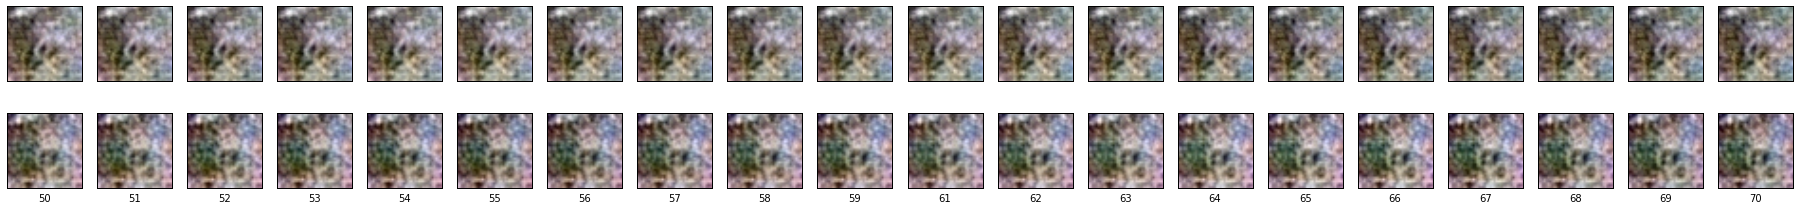

In [614]:

m_samp = np.round(linspace(50, 70, 20))

figure(figsize=(32,3.5))
for ix,imx in enumerate(m_samp):
    
    ax = subplot(2, len(m_samp), ix+1+0*len(m_samp))
    recon = np.dot(ic_decode1[imx+K,:], ic_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = subplot(2, len(m_samp), ix+1+1*len(m_samp))
    recon = np.dot(pc_decode1[imx+K,:], pc_comp)
    reconr = recon.reshape(patch_size[0], patch_size[1], 3)
    imshow(norm_range(reconr))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlabel(str(int(imx)))

** Figure 7: Recall of the second encoded image with increased images stored. ** Top row: decoded reconstruction of the image from hypervector with ICA basis. Bottom row: decoded reconstruction of the image of image from hypervector with PCA basis. Numbers at bottom indicate total number of images stored in the hypervector (minus 1). 

